In [1]:
%pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.4/372

In [36]:
# import required libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import TransformerModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.dataprocessing.transformers import Scaler
from statsmodels.tsa.seasonal import seasonal_decompose

In [37]:
data = pd.read_parquet('/content/drive/MyDrive/TimeSeries/Mittelbuenden/train.parquet')
data['Date'] = pd.to_datetime(data['Date'], utc=True)
data.set_index('Date', inplace=True)

In [47]:
consumption_ts = TimeSeries.from_dataframe(data[['Consumption']])

# preprocess data
train_val_split = int(len(consumption_ts)*0.8) # use first 80% of data for training
train_ts = consumption_ts[:train_val_split]
val_ts = consumption_ts[train_val_split:]

# check seasonality and stationarity of the data
seasonality = check_seasonality(train_ts)
if seasonality != 7: # daily data has seasonality of 7
    train_resid = seasonal_decompose(train_ts.pd_dataframe(), model='additive', period=7).resid
    train_ts = TimeSeries.from_series(train_resid)
    val_resid = seasonal_decompose(val_ts.pd_dataframe(), model='additive', period=7).resid
    val_ts = TimeSeries.from_series(val_resid)

# scale data
scaler = Scaler()
train_ts_scaled = scaler.fit_transform(train_ts)
val_ts_scaled = scaler.transform(val_ts)

# fill NaNs with mean value
train_ts_scaled = train_ts_scaled.pd_dataframe().fillna(train_ts_scaled.pd_dataframe().mean())
train_ts_scaled = TimeSeries.from_dataframe(train_ts_scaled)

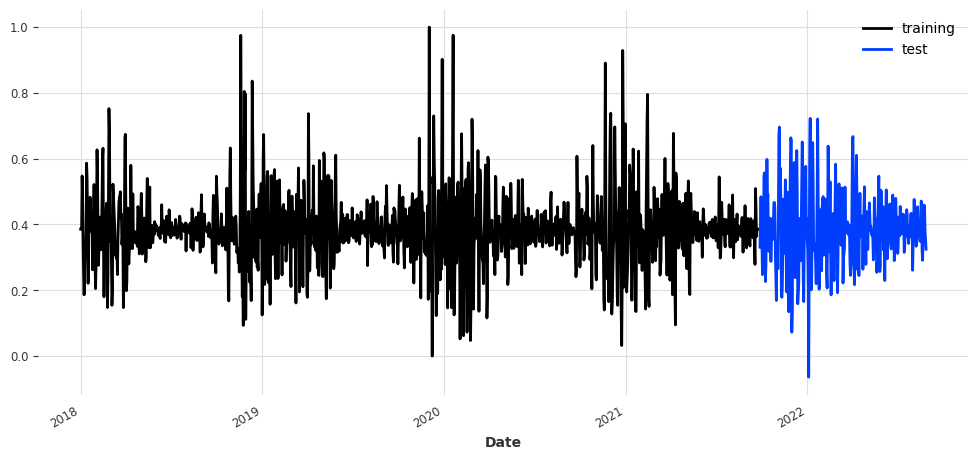

In [48]:
plt.figure(101, figsize=(12, 5))
train_ts_scaled.plot(label='training')
val_ts_scaled.plot(label='test')
plt.legend()

In [54]:
# create input/output sequences
input_width = 7 # use weekly data as input
output_width = 1 # predict next day's consumption

In [56]:
# create and train model
model = TransformerModel(input_chunk_length=input_width, output_chunk_length=output_width, dropout=0.1)
model.fit(train_ts_scaled, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 65    
------------------------------------------------------------
548 K     Trainable params
0         Non-trainable params
548 K     Tot

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


TransformerModel(d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=7, output_chunk_length=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

NameError: ignored

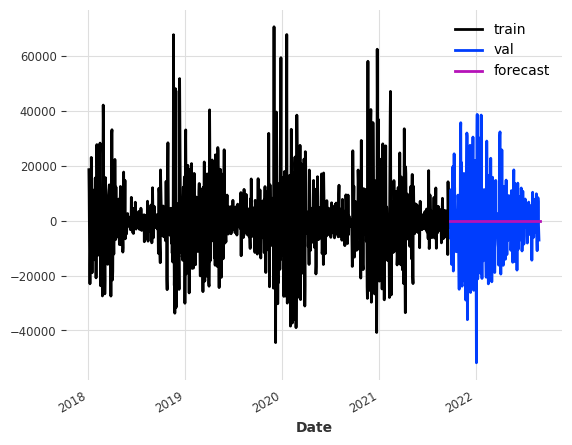

In [58]:
# make predictions
forecast = model.predict(n=len(val_ts))
forecast = scaler.inverse_transform(forec)
# plot results
train_ts.plot(label='train')
val_ts.plot(label='val')
forecast.plot(label='forecast')
plt.title(f'MAPE: {error:.2f}%')
plt.legend()
plt.show()

In [ ]:


# create and train model
model = TransformerModel(input_chunk_length=input_width, output_chunk_length=output_width, num_heads=4, num_stacks=3, dropout=0.1)
model.fit(train_data, verbose=True)

# make predictions
forecast = model.predict(n=len(val_ts))

# calculate error metric
error = mape(forecast, val_data)

# plot results
train_ts.plot(label='train')
val_ts.plot(label='val')
forecast.plot(label='forecast')
plt.title(f'MAPE: {error:.2f}%')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel
from darts.metrics import mape, rmse, mae
from torchmetrics import MeanAbsolutePercentageError
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model

EPOCHS = 200
INLEN = 32          # input size
FEAT = 32           # d_model = number of expected features in the inputs, up to 512    
HEADS = 4           # default 8
ENCODE = 4          # encoder layers
DECODE = 4          # decoder layers
DIM_FF = 128        # dimensions of the feedforward network, default 2048
BATCH = 32          # batch size
ACTF = "relu"       # activation function, relu (default) or gelu
SCHLEARN = None     # a PyTorch learning rate scheduler; None = constant rate
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
DROPOUT = 0.1       # dropout rate
N_FC = 1            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = 3          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

In [ ]:
data = pd.read_parquet('/content/drive/MyDrive/TimeSeries/Mittelbuenden/train.parquet')
data['Date'] = pd.to_datetime(data['Date'], utc=True)
data.set_index('Date', inplace=True)
# # data = data.resample('H').sum(min_count=1)
# data = data.resample('D').sum(min_count=1)
data=data.sort_index()
data['Covid'] = 0
data.loc[(data.index >= '2020-02-01') & (data.index <= '2021-06-01'), 'Covid'] = 1
TEST_END = '2022-01-01'
TRAIN_END = '2021-01-01'
TRAIN_END = pd.to_datetime(TRAIN_END)
data = data.loc[data.index < TEST_END]
# data['TimeIndex'] = np.arange(len(data))
# data = data.drop(columns=['TimeIndex'])
data

,Consumption,Temperature,Covid
Date,,,
2018-01-01 00:00:00+00:00,437079.017331,4.191667,0
2018-01-02 00:00:00+00:00,441247.012018,2.158333,0
2018-01-03 00:00:00+00:00,428372.492620,2.604167,0
2018-01-04 00:00:00+00:00,432217.202020,1.508333,0
2018-01-05 00:00:00+00:00,410469.442938,3.991667,0
...,...,...,...
2021-12-27 00:00:00+00:00,451012.930925,3.604167,0
2021-12-28 00:00:00+00:00,445811.645751,4.650000,0
2021-12-29 00:00:00+00:00,454444.875945,3.537500,0


Data

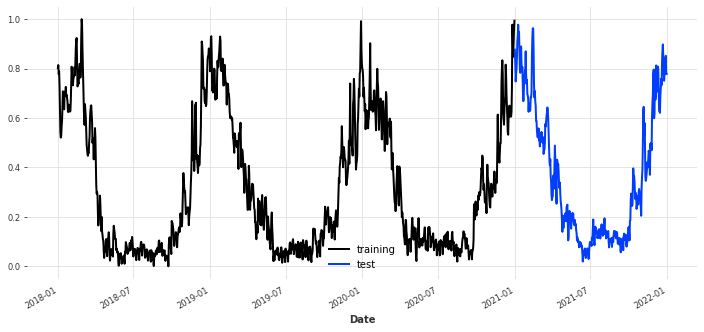

In [ ]:
series_scaler = Scaler()
series = TimeSeries.from_dataframe(df=data, value_cols='Consumption')
series_unsc = series
series = series_scaler.fit_transform(series)

train, test = series.split_before(TRAIN_END)
train_unsc, test_unsc = series_unsc.split_before(TRAIN_END)

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
test.plot(label='test')
plt.legend()

Covariates

Text(0.5, 1.0, 'Covariates (Covid)')

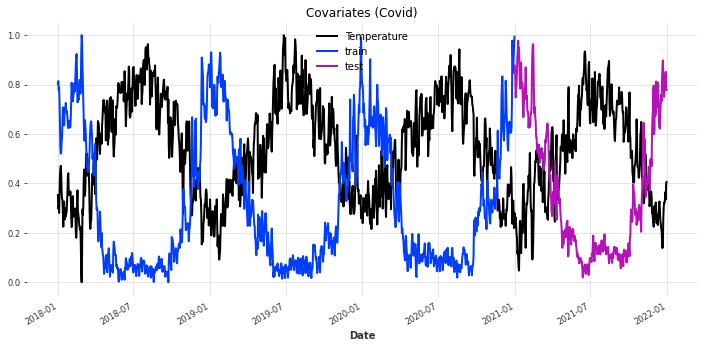

In [ ]:
covid = TimeSeries.from_dataframe(df=data, value_cols='Covid')
covid = covid[1:] # it's somehow longer than the others
year = datetime_attribute_timeseries(series, attribute="year")
month = datetime_attribute_timeseries(series, attribute="month", cyclic=True)
weekday = datetime_attribute_timeseries(series, attribute="weekday", cyclic=True)
temperature = TimeSeries.from_dataframe(df=data, value_cols='Temperature')

past_scaler = Scaler()


### past
past_covariates = temperature#.stack(weekday).stack(month).stack(year)
past_covariates = past_covariates#.add_holidays(country_code="CH")
past_covariates = past_covariates.astype(np.float32)
past_covariates = past_scaler.fit_transform(past_covariates)

plt.figure(101, figsize=(12, 5))
past_covariates.plot()
train.plot(label='train')
test.plot(label='test')
plt.title("Covariates (Covid)")

TF

In [ ]:
torch_metrics = MeanAbsolutePercentageError()
model = TransformerModel(
                    input_chunk_length = INLEN,
                    output_chunk_length = N_FC,
                    batch_size = BATCH,
                    n_epochs = EPOCHS,
                    model_name = 'testmodel',
                    nr_epochs_val_period = VALWAIT,
                    d_model = FEAT,
                    nhead = HEADS,
                    num_encoder_layers = ENCODE,
                    num_decoder_layers = DECODE,
                    dim_feedforward = DIM_FF,
                    dropout = DROPOUT,
                    activation = ACTF,
                    random_state=RAND,
                    torch_metrics=torch_metrics,
                    likelihood=QuantileRegression(quantiles=QUANTILES), 
                    optimizer_kwargs={'lr': LEARN},
                    add_encoders={"cyclic": {"future": ["dayofweek", "month"]}},
                    save_checkpoints=True,
                    force_reset=True
                    )

In [ ]:
model.fit(train,
          past_covariates=past_covariates,
          val_series=test,
          val_past_covariates=past_covariates
          )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 96    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 118 K 
6 | decoder             | Linear              | 231   
------------------------------------------------------------
119 K     Trainable params
0         Non-trainable params
119 K     Tot

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


In [ ]:
bmodel = model.load_from_checkpoint(model_name='testmodel', best=True)

In [ ]:
ts_tpred = bmodel.predict(n=365,
                         past_covariates=past_covariates,
                         num_samples=N_SAMPLES
                         )


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [ ]:
unsc_ts_tpred = series_scaler.inverse_transform(ts_tpred)

16568.309942179585
5.792893061217528


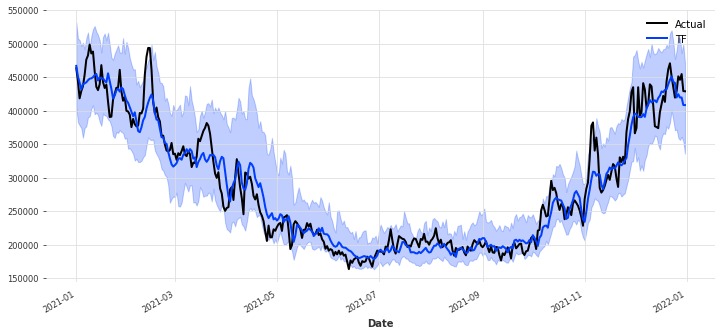

In [ ]:
plt.figure(101, figsize=(12, 5))
test_unsc.plot(label='Actual')
unsc_ts_tpred.plot(label='TF')
tft_mae = mae(test_unsc, unsc_ts_tpred)
tft_mape = mape(test_unsc, unsc_ts_tpred)
print(tft_mae)
print(tft_mape)